In [1]:
import os 
os.chdir('../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.RiskSLIM as slim
import utils.stumps as stumps
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from pprint import pprint
from riskslim.helper_functions import load_data_from_csv, print_model

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\interpretable-machine-learning


C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



### EBM

In [2]:
train_data = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_train.csv").sort_values('person_id')
train_data = train_data.drop(['person_id', 'screening_date', 'arnold_nca_raw', 'arnold_nvca_raw', 'arnold_fta_raw'], axis=1)
train_x = train_data.loc[:, :'current_violence20']
train_y = train_data['general_two_year']
cols = train_x.columns

In [7]:
ebm = ExplainableBoostingClassifier(feature_names=cols,
                                    n_estimators=40,  
                                    max_tree_splits=2, 
                                    learning_rate=0.3,
                                    random_state=816).fit(train_x, train_y)

In [8]:
ebm_global = ebm.explain_global()
show(ebm_global)

### Additive Stumps

In [2]:
## load train & test
train_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_train_stumps.csv").sort_values('person_id')
test_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_test_stumps.csv").sort_values('person_id')

X_train_stumps = train_stumps.loc[:,:'current_violence201'].copy()
X_test_stumps = test_stumps.loc[:,:'current_violence201'].copy()
Y_train_stumps = train_stumps['general_two_year'].values.copy()
Y_test_stumps = test_stumps['general_two_year'].values.copy()
Y_train_stumps[Y_train_stumps == -1] = 0
Y_test_stumps[Y_test_stumps == -1] = 0
cols = X_train_stumps.columns[3:]

In [3]:
best_stump_model = stumps.stump_model(X_train_stumps, 
                                      Y_train_stumps, 
                                      X_test_stumps, 
                                      Y_test_stumps, 
                                      c=0.003, 
                                      columns=cols, 
                                      seed=816)

In [4]:
stumps.latex_stump_table(best_stump_model['coefs'], 
                         best_stump_model['features'], 
                         best_stump_model['intercept'], 
                         best_stump_model['dictionary'])

\begin{{tabular}}{{|l|r|r|}} \hline
1. age_at_current_charge19 & 0.03756419757996402 & +... \\ \hline
2. age_at_current_charge20 & 0.027090677290429854 & +... \\ \hline
3. age_at_current_charge21 & 0.009545889559874562 & +... \\ \hline
4. age_at_current_charge24 & 0.04040097887096355 & +... \\ \hline
5. age_at_current_charge27 & 0.028081628968668754 & +... \\ \hline
6. age_at_current_charge35 & 0.0029517455565641775 & +... \\ \hline
7. age_at_current_charge39 & 0.09514596655244291 & +... \\ \hline
8. age_at_current_charge43 & 0.06732959051439423 & +... \\ \hline
9. age_at_current_charge47 & 0.06581538360886345 & +... \\ \hline
10. p_arrest2 & 0.722067231459698 & +... \\ \hline
11. p_arrest3 & 0.37359924398766364 & +... \\ \hline
12. p_arrest4 & 0.23376213600922943 & +... \\ \hline
13. p_arrest5 & 0.17467746103106568 & +... \\ \hline
14. p_arrest6 & 0.0946401209694806 & +... \\ \hline
15. p_violence1 & 0.10167056919844984 & +... \\ \hline
16. p_felony1 & 0.16220723923938712 & +... \\ \h

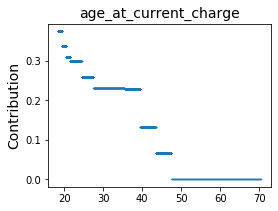

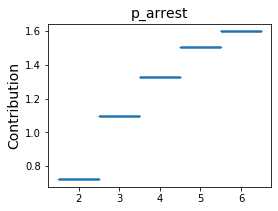

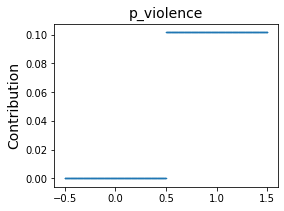

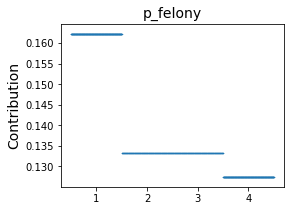

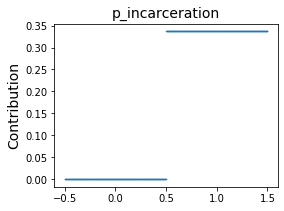

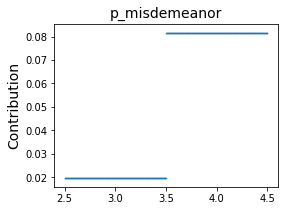

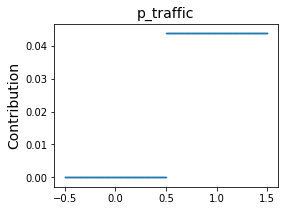

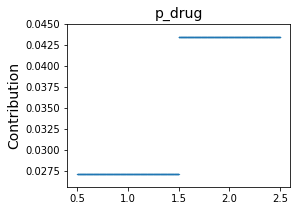

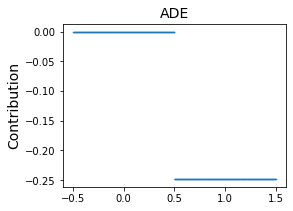

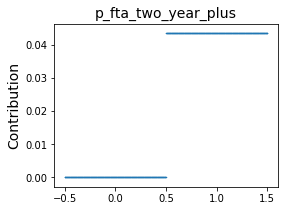

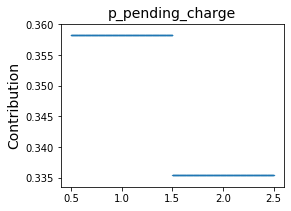

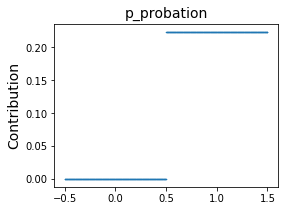

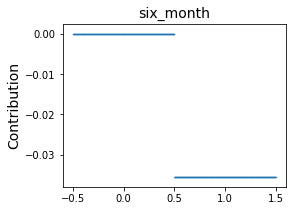

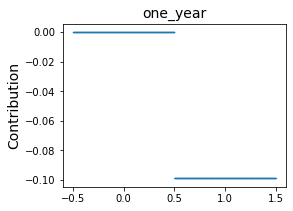

In [5]:
stumps.stump_plots(best_stump_model['features'], best_stump_model['coefs'], indicator="KY")

### Visualization for 'p_fta_two_year'

In [6]:
label = 'p_fta_two_year'
features = best_stump_model['features']
coefs = best_stump_model['coefs']
cutoff_values = []
cutoffs = []

In [7]:
## sub-features
sub_features = np.array(np.array(features)[[label in k for k in features]])[:-1]

for j in sub_features:
    cutoff_values.append( round(coefs[np.where(np.array(features) == j)[0][0]], 3))
    cutoffs.append(int(j[j.find(label)+len(label):])) 
    
## prepare cutoffs
cutoff_prep = []
cutoff_values_prep = []

for n in range(len(cutoffs)-1):
    cutoff_prep.append(np.linspace(cutoffs[n]-0.5, cutoffs[n+1]-0.5, 1000))
    cutoff_values_prep.append(np.repeat(round(np.sum(cutoff_values[:n+1]),3), 1000))
    
cutoff_prep.append(np.linspace(cutoffs[-1]-0.5, cutoffs[-1]+0.5, 1000))
cutoff_values_prep.append(np.repeat(np.sum(cutoff_values), 1000))

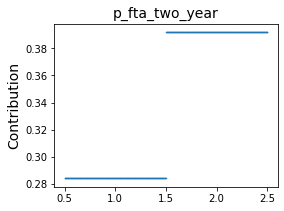

In [8]:
## visualization
unique = np.unique(cutoff_values_prep)
unique_len = len(unique)
plt.figure(figsize=(4,3))
plt.scatter(cutoff_prep, cutoff_values_prep, s=0.05)
plt.title(label, fontsize=14)
plt.ylabel('Contribution', fontsize=14)
plt.show()  

### RiskSLIM

In [19]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/data/ky-data/kentucky_stumps.csv").sort_values('person_id')

## single stump model
single_stump_model = stumps.stump_model(X_train_stumps, 
                                        Y_train_stumps, 
                                        X_test_stumps, 
                                        Y_test_stumps, 
                                        c=0.0011,    
                                        columns=cols, 
                                        seed=816)

In [20]:
selected_features = ['general_two_year'] + single_stump_model['features']
sub_train_data = train_stumps[selected_features]
sub_test_data = test_stumps[selected_features]

## split x 
sub_train_X = sub_train_data.iloc[:,1:]
sub_train_X.insert(0, '(Intercept)', 1)
sub_cols = sub_train_X.columns.tolist()
sub_train_X = sub_train_X.values
sub_test_X = sub_test_data.iloc[:,1:].values

## split y
sub_train_Y = sub_train_data.iloc[:,0].values.reshape(-1,1)
sub_test_Y = sub_test_data.iloc[:,0].values.reshape(-1,1)

## sample weight
sample_weights = np.repeat(1, len(sub_train_Y))

In [21]:
new_train_data = {
    'X': sub_train_X,
    'Y': sub_train_Y,
    'variable_names': sub_cols,
    'outcome_name': 'general_two_year',
    'sample_weights': sample_weights
}

In [22]:
model_info, mip_info, lcpa_info = slim.risk_slim(new_train_data, 
                                                 max_coefficient=5, 
                                                 max_L0_value=5, 
                                                 c0_value=1e-6, 
                                                 max_offset=100, 
                                                 max_runtime=1000)
print_model(model_info['solution'], new_train_data)

setting c0 = 0.0 to ensure that intercept is not penalized
02/15/20 @ 11:37 AM | 183 rows in lookup table
02/15/20 @ 11:37 AM | ------------------------------------------------------------
02/15/20 @ 11:37 AM | runnning initialization procedure
02/15/20 @ 11:37 AM | ------------------------------------------------------------
02/15/20 @ 11:37 AM | CPA produced 2 cuts
02/15/20 @ 11:37 AM | running naive rounding on 4 solutions
02/15/20 @ 11:37 AM | best objective value: 0.6931
02/15/20 @ 11:37 AM | rounding produced 4 integer solutions
02/15/20 @ 11:37 AM | best objective value is 0.6931
02/15/20 @ 11:37 AM | running sequential rounding on 4 solutions
02/15/20 @ 11:37 AM | best objective value: 0.6931
02/15/20 @ 11:37 AM | sequential rounding produced 0 integer solutions
02/15/20 @ 11:37 AM | polishing 4 solutions
02/15/20 @ 11:37 AM | best objective value: 0.6931
02/15/20 @ 11:37 AM | polishing produced 4 integer solutions
02/15/20 @ 11:37 AM | initialization produced 7 feasible soluti

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
02/15/20 @ 11:37 AM | adding 249 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.4830.
Tried aggregator 1 time.
Reduced MIP has 28 rows, 30 columns, and 81 nonzeros.
Reduced MIP has 13 binaries, 15 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.04 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl